In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import struct, pickle
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator

from utils.label_utils import label_blobs, get_labels
from utils.oscillons import get_oscillon_coms
from utils.volume_utils import shift_volume
from utils.latticeeasy import *
from utils.extract_utils import *
from utils.visualisation_utils import scatterfield_3D, annotate_oscillons, get_opacity

In [2]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 10})
rc('text', usetex=True)
rc('image', cmap='gist_heat_r')
rc('axes', **{'titlesize': 10})

plt.rcParams['axes.axisbelow'] = True

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load data

In [1]:
# output_dir = "/media/yangelaxue/Expansion/Uni/Masters/More_LE_data/alpha_beta-0.5_50"
# output_dir = "/media/yangelaxue/TRANSFER/Colliding_Oscillons/CE1"
output_dir = "/media/yangelaxue/TRANSFER/Colliding_Oscillons/alpha_beta-0.75_100"
data = LATTICEEASY(output_dir)
data.__dict__

NameError: name 'LATTICEEASY' is not defined

In [4]:
timeslice = 5

alpha, beta, phi_0 = data.alpha, data.beta, data.phi_0
A, B, r, s = data.rescale_A, data.rescale_B, data.rescale_r, data.rescale_s
a, ap, t = data.a[timeslice], data.ap[timeslice], data.t[timeslice]
alpha, beta, phi_0, A, B, r, s, a, ap, t

(0.75,
 100.0,
 0.154365,
 6.478152430926699,
 2.389997421234312e-06,
 1.7142857142857142,
 0.42857142857142855,
 20.042118,
 0.03545834,
 301.15863)

In [5]:
phi, phip = load_phi(output_dir, data.domain_dimensions, timeslice), load_phip(output_dir, data.domain_dimensions, timeslice)
Edens = get_Edens_pr(phi, phip, a, ap, alpha, beta, phi_0, data.domain_width_pr/data.domain_dimensions)

In [6]:
Edens_Rel = Edens/Edens.mean()

In [7]:
n_means = 4
oscillons_fname = os.path.join(output_dir,f"oscillons_nmeans{n_means}_{data.t[timeslice]}.p")

if os.path.exists(oscillons_fname):
    oscillons = pickle.load(open(oscillons_fname, "rb"))
else:
    min_n_cells = int(np.product(data.domain_dimensions) * (.02)**3)
    oscillons = label_blobs(Edens_Rel, n_means, min_n_cells, periodic=True)
    pickle.dump(oscillons, open(oscillons_fname, "wb"))
    
np.unique(oscillons)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

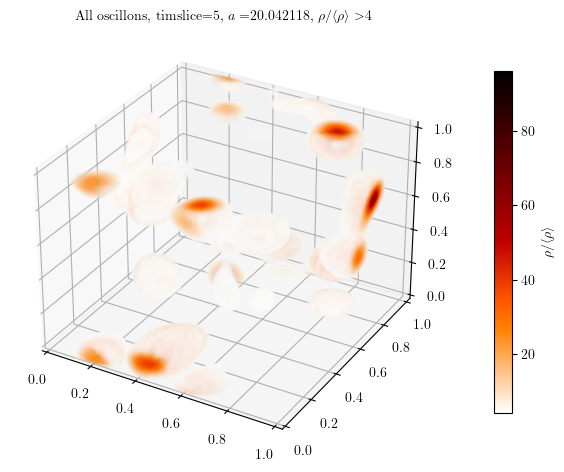

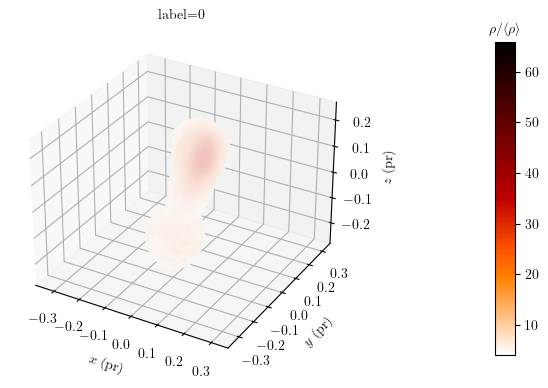

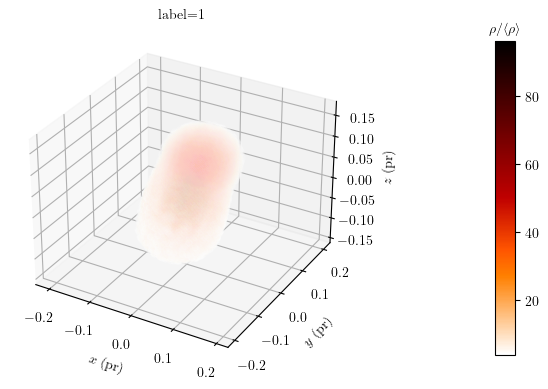

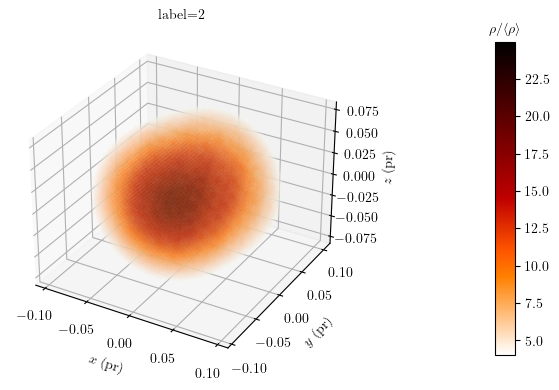

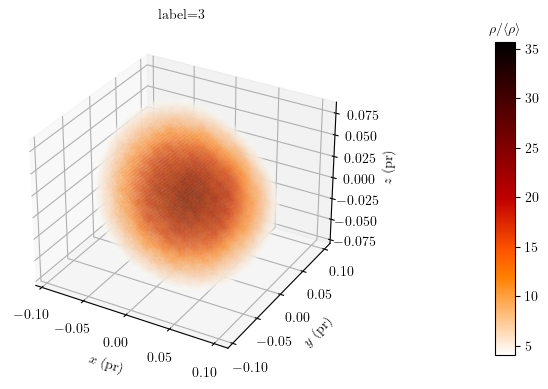

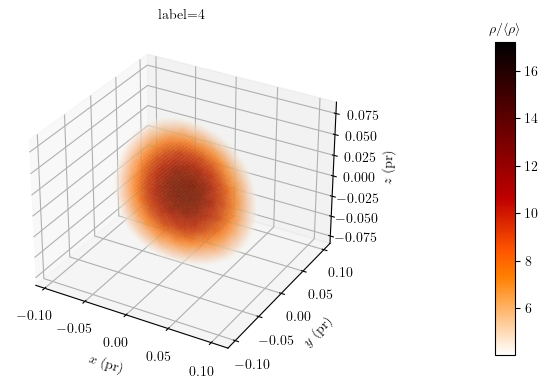

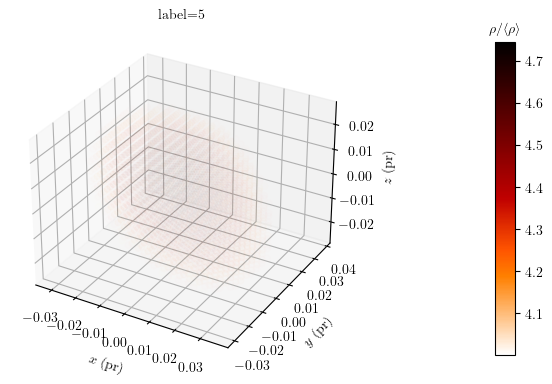

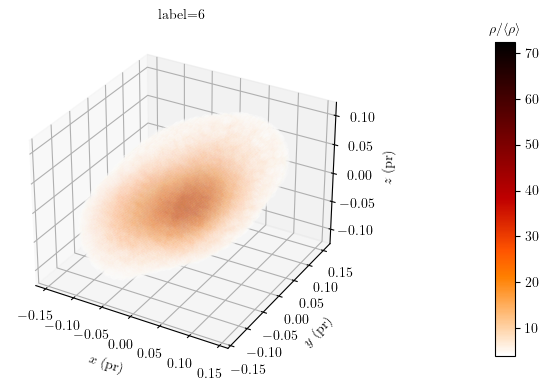

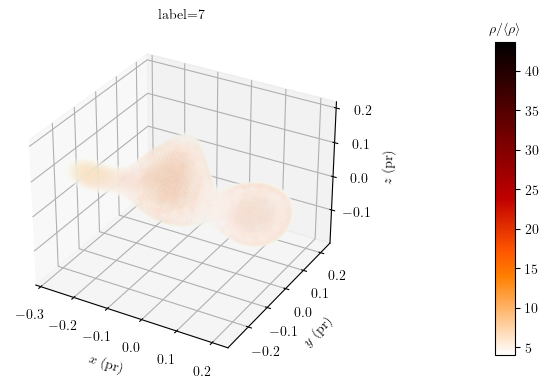

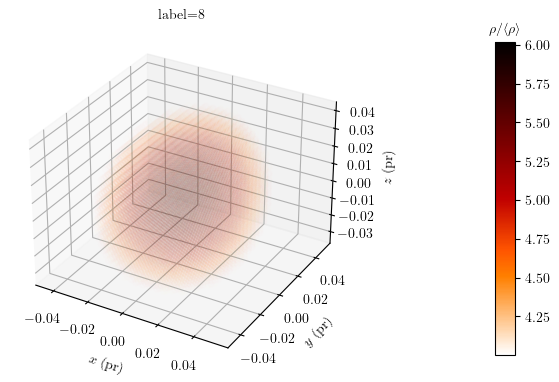

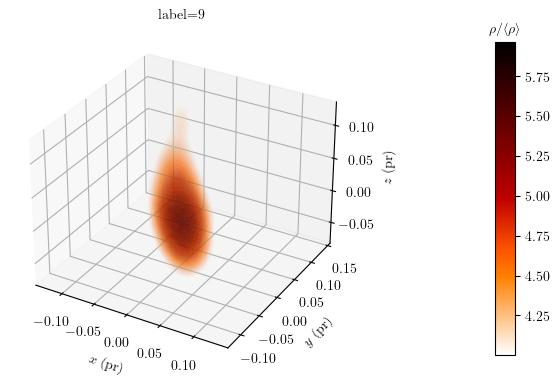

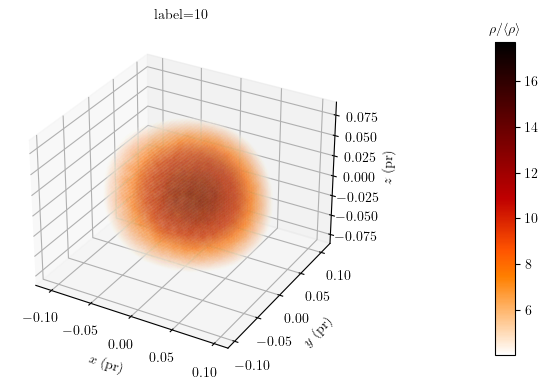

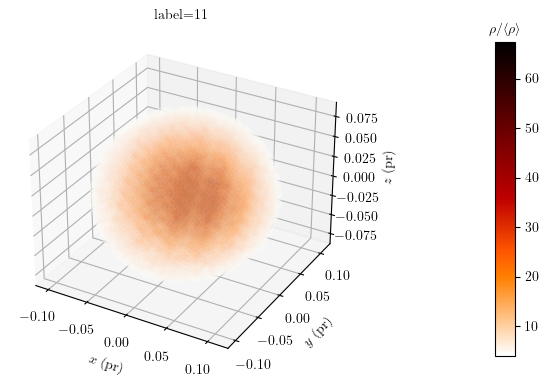

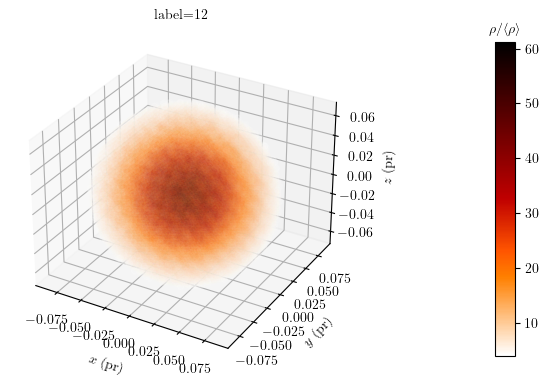

In [8]:
labels = get_labels(oscillons)
coms = [get_oscillon_coms(Edens_Rel, data.domain_width_pr, oscillons, label)[1] for label in labels]

xyz = [np.linspace(0,width,dim) for width,dim in zip(data.domain_width_pr,data.domain_dimensions)]
XYZ = np.meshgrid(*xyz,indexing='ij')

where = oscillons>-1
fig, ax, scatter = scatterfield_3D(
    Edens_Rel[where],
    tuple(X[where] for X in XYZ),
    1/4
)

fig.colorbar(scatter, pad=.1, shrink=.6, label=fr'$\rho/\langle\rho\rangle$')
# annotate_oscillons(ax, labels, coms)
ax.set_xlim(0, data.domain_width_pr[0])
ax.set_ylim(0, data.domain_width_pr[1])
ax.set_zlim(0, data.domain_width_pr[2])
ax.set_title(fr"All oscillons, timslice={timeslice}, $a=${a}, $\rho/\langle\rho\rangle>${n_means}")

plt.show()

for i, label in enumerate(labels):
    
#     if i!=16: continue
    com_idx, = get_oscillon_coms(Edens,data.domain_width_pr,oscillons,label)[0]
    Edens_Rel_sh, oscillons_sh = shift_volume(com_idx,Edens_Rel,oscillons,)
    com_sh = get_oscillon_coms(Edens_Rel_sh,data.domain_width_pr,oscillons_sh,label)[1]
    
    where = oscillons_sh==label
    opacity = get_opacity(np.abs(Edens_Rel_sh))
    
    fig = plt.figure(figsize=(6,6),tight_layout=True)
    ax = fig.add_subplot(111,projection='3d')
    
    scatter = ax.scatter(*tuple((X-X.mean())[where] for X in XYZ), alpha=opacity[where]*1/3, c=Edens_Rel_sh[where])
    
    cbar = fig.colorbar(scatter, pad=.25, shrink=.55, aspect=15)
    cbar.ax.set_title(r'$\rho/\langle\rho\rangle$')
    ax.set_xlabel(r"$x$ (pr)")
    ax.set_ylabel(r"$y$ (pr)")
    ax.set_zlabel(r"$z$ (pr)")
    ax.set_aspect('equal')
    
    ax.set_title(f"{label=}")
    
#     plt.savefig("images_for_thesis/Edens alpha-beta_0.55-45 bad oscillon.png",dpi=400,facecolor='w',bbox_inches='tight')
    plt.show()

# Extract Oscillon

In [132]:
# 2, 12
label = 11

In [133]:
pad = 30

phi_cr, phip_cr, Edens_cr = crop(Edens,oscillons,label,pad,phi,phip,Edens)

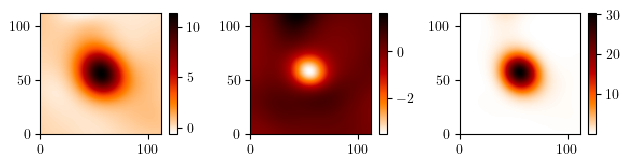

In [138]:
shape = phi_cr.shape

cross = (shape[0]//2, slice(0,shape[0],1), slice(0,shape[0],1), )
# cross = (slice(0,shape[0],1), shape[0]//2, slice(0,shape[0],1), )
# cross = (slice(0,shape[0],1), slice(0,shape[0],1), shape[0]//2, )

vals = [phi_cr[cross], phip_cr[cross], Edens_cr[cross]]

fig, axes = plt.subplots(1,3,tight_layout=True,)

for i, (ax, val) in enumerate(zip(axes,vals)):
    
    mesh = ax.pcolormesh(val)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=.08, pad=0.08)
    cbar = fig.colorbar(mesh,cax=cax,)
    
#     if False:
# #     if i in [0,1]:
# #         peak = [val.min(), val.max()]
#         peak = val.min() if abs(val.min())>val.max() else val.max()
#         ax.contour(val,[peak/(3*np.exp(1))],colors='g')
#     if True:
#         peak = Edens_cr.max()
#         ax.contour(vals[2],[peak/(6*np.exp(1))],colors='b')
    
    ax.set_aspect('equal')

Relabeling blobs in ascending order: 100%|███████| 3/3 [00:00<00:00, 374.88it/s]


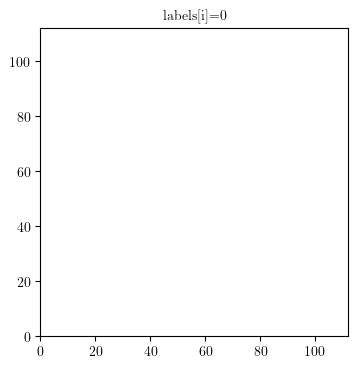

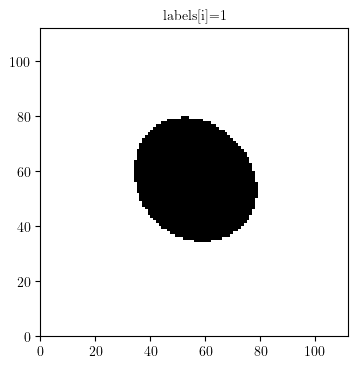

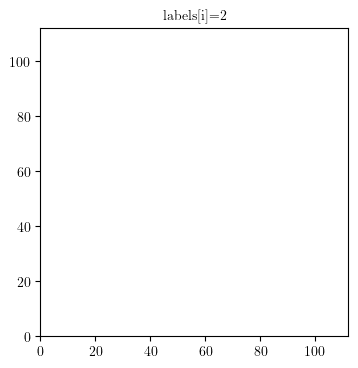

In [139]:
cross = (shape[0]//2, slice(0,shape[0],1), slice(0,shape[0],1), )
# cross = (slice(0,shape[0],1), shape[0]//2, slice(0,shape[0],1), )
# cross = (slice(0,shape[0],1), slice(0,shape[0],1), shape[0]//2, )

threshold = Edens_cr.max()/(3*np.exp(1))
mask_init = (Edens_cr>threshold).astype(float)

osc_mask = label_blobs(Edens_cr, threshold, 1, False)

labels = get_labels(osc_mask)

for i in range(len(labels)):
    
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    
    ax.pcolormesh((osc_mask==i)[cross])
    ax.set_title(f"{labels[i]=}")
    ax.set_aspect('equal')
    plt.show()

In [140]:
sig = 5

mask_blurred_init = gaussian_filter((osc_mask==1).astype(float), sig)
mask = mask_blurred_init.copy()
mask[mask>0.02] = 1
mask[mask<=0.02] = 0
mask_blurred = gaussian_filter(mask, sig)

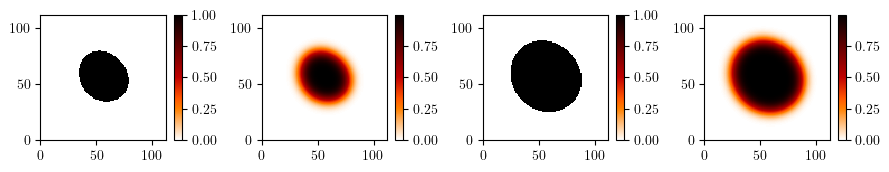

In [141]:
for k in range(shape[0]//2,shape[0]//2+1):
# for k in range(shape[0]):

    # cross = shape[0]//2
    cross = (k,slice(0,shape[0],1), slice(0,shape[0],1), )
    vals = [mask_init[cross], mask_blurred_init[cross], mask[cross], mask_blurred[cross]]

    fig, axes = plt.subplots(1,4,figsize=(9,4),tight_layout=True,)

    for i, (ax, val) in enumerate(zip(axes,vals)):

        mesh = ax.pcolormesh(val)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size=.08, pad=0.08)
        cbar = fig.colorbar(mesh,cax=cax,)

    #     if False:
    # #     if i in [0,1]:
    # #         peak = [val.min(), val.max()]
    #         peak = val.min() if abs(val.min())>val.max() else val.max()
    #         ax.contour(val,[peak/(3*np.exp(1))],colors='g')
    #     if True:
    #         peak = Edens_cr.max()
    #         ax.contour(vals[2],[peak/(6*np.exp(1))],colors='b')

        ax.set_aspect('equal')
    
    plt.show()

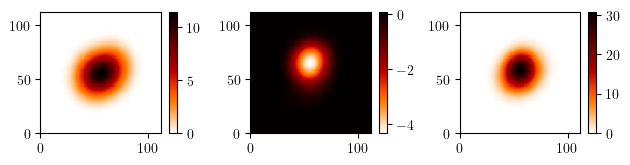

In [142]:
cross = (shape[0]//2, slice(0,shape[0],1), slice(0,shape[0],1), )
cross = (slice(0,shape[0],1), shape[0]//2, slice(0,shape[0],1), )
# cross = (slice(0,shape[0],1), slice(0,shape[0],1), shape[0]//2, )

vals = [(phi_cr*mask_blurred)[cross], (phip_cr*mask_blurred)[cross], (Edens_cr*mask_blurred)[cross]]

fig, axes = plt.subplots(1,3,tight_layout=True,)

for i, (ax, val) in enumerate(zip(axes,vals)):
    
    mesh = ax.pcolormesh(val)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=.08, pad=0.08)
    cbar = fig.colorbar(mesh,cax=cax,)
    
#     if False:
# #     if i in [0,1]:
# #         peak = [val.min(), val.max()]
#         peak = val.min() if abs(val.min())>val.max() else val.max()
#         ax.contour(val,[peak/(3*np.exp(1))],colors='g')
#     if True:
#         peak = Edens_cr.max()
#         ax.contour(vals[2],[peak/(6*np.exp(1))],colors='b')
    
    ax.set_aspect('equal')

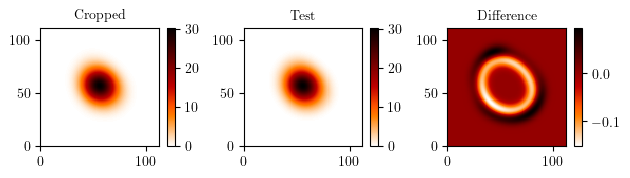

In [143]:
# cross = shape[0]//2
cross = (shape[0]//2, slice(0,shape[0],1), slice(0,shape[0],1))

Edens_test = get_Edens_pr(phi_cr*mask_blurred, phip_cr*mask_blurred, a, ap, alpha, beta, phi_0, data.domain_width_pr/data.domain_dimensions)

vals = [(Edens_cr*mask_blurred)[cross], Edens_test[cross], (Edens_cr*mask_blurred-Edens_test)[cross]]
titles = ["Cropped", "Test", "Difference"]

fig, axes = plt.subplots(1,3,tight_layout=True,)

for i, (ax, val) in enumerate(zip(axes,vals)):
    
    mesh = ax.pcolormesh(val)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=.08, pad=0.08)
    cbar = fig.colorbar(mesh,cax=cax,)
    
#     if False:
# #     if i in [0,1]:
# #         peak = [val.min(), val.max()]
#         peak = val.min() if abs(val.min())>val.max() else val.max()
#         ax.contour(val,[peak/(3*np.exp(1))],colors='g')
#     if True:
#         peak = Edens_cr.max()
#         ax.contour(vals[2],[peak/(6*np.exp(1))],colors='b')
    
    ax.set_title(titles[i])
    ax.set_aspect('equal')

In [144]:
domain_width_ext = data.domain_width_pr*shape/data.domain_dimensions
domain_width_ext, data.domain_width_pr

(array([0.44251944, 0.44251944, 0.44251944]),
 array([1.011473, 1.011473, 1.011473]))

# Interpolate

In [145]:
shape_i = (128,128,128)
# shape_i = (256,256,256)
shape, shape_i

((112, 112, 112), (128, 128, 128))

In [146]:
domain_width_ext = data.domain_width_pr*shape/data.domain_dimensions
domain_width_ext, data.domain_width_pr

(array([0.44251944, 0.44251944, 0.44251944]),
 array([1.011473, 1.011473, 1.011473]))

In [147]:
phi_i, phip_i, Edens_i = interpolate(shape_i, phi_cr*mask_blurred, phip_cr*mask_blurred, Edens_cr*mask_blurred)

In [148]:
Edens_i_test = get_Edens_pr(phi_i, phip_i, a, ap, alpha, beta, phi_0, domain_width_ext/shape_i)

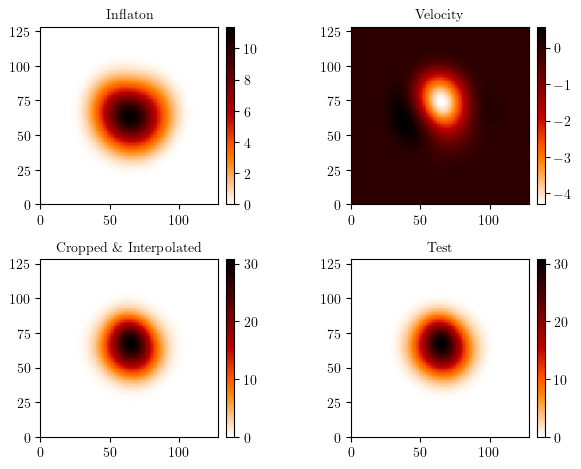

In [149]:
# cross = shape[0]//2
cross = (slice(0,shape_i[0],1), slice(0,shape_i[0],1), shape_i[0]//2)
vals = [phi_i[cross], phip_i[cross], Edens_i[cross], Edens_i_test[cross]]
titles = [r"Inflaton", r"Velocity", "Cropped \& Interpolated", "Test"]

fig, axes = plt.subplots(2,2,tight_layout=True,)

for i, (ax, val) in enumerate(zip(axes.flatten(),vals)):
    
    mesh = ax.pcolormesh(val)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=.08, pad=0.08)
    cbar = fig.colorbar(mesh,cax=cax,)
    
#     if False:
# #     if i in [0,1]:
# #         peak = [val.min(), val.max()]
#         peak = val.min() if abs(val.min())>val.max() else val.max()
#         ax.contour(val,[peak/(3*np.exp(1))],colors='g')
#     if True:
#         peak = Edens_cr.max()
#         ax.contour(vals[2],[peak/(6*np.exp(1))],colors='b')
    
    ax.set_title(titles[i])
    ax.set_aspect('equal')
    
plt.show()

# difference = np.abs((Edens_i-Edens_i_test)/Edens_i)[cross]
# difference = difference * (difference<1e9)
# # difference = mask_blurred[cross]
# # difference = (difference>0)

# mesh = plt.pcolormesh(difference,cmap='gist_heat')
# ax = plt.gca()
# ax.set_aspect('equal')
# ax.set_title("Difference")
# plt.colorbar()
# plt.show()

Text(0, 0.5, 'Test')

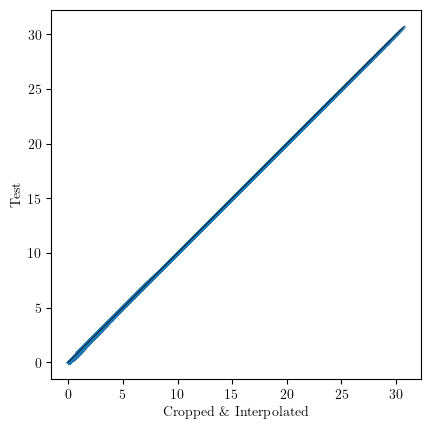

In [150]:
vmax = max(Edens_i_test.max(), Edens_i.max())
plt.plot([0,vmax],[0,vmax],c='k',lw=.5)

plt.scatter(Edens_i.flatten(), Edens_i_test.flatten(), marker='x', alpha=.1, s=2)
ax = plt.gca()
ax.set_aspect('equal')
ax.set_xlabel("Cropped \& Interpolated")
ax.set_ylabel("Test")
# plt.colorbar()

# Save oscillons as grid.img

In [151]:
a, ap, t, domain_width_ext, data.dt_pr, data.dt_pr/(domain_width_ext/shape_i), 3**-.5

(20.042118,
 0.03545834,
 301.15863,
 array([0.44251944, 0.44251944, 0.44251944]),
 0.001,
 array([0.28925283, 0.28925283, 0.28925283]),
 0.5773502691896257)

In [152]:
"""
Advance phi by half a step.
"""

dt_pr = data.dt_pr
# dt_pr = 0.0005

print(dt_pr)

phi_i_adv = phi_i + dt_pr/2*phip_i

0.001


In [153]:
"""
Save image.
"""

n_points = np.product(shape_i)

save_folder = output_dir.split('/')[-1]+f"_{data.t[timeslice]}/osc{label}_{shape_i[0]}"
save_dir = os.path.join(output_dir,'..',save_folder)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

fname_o = f"osc{label}.img"
datname_o = f"osc{label}.dat"

with open(os.path.join(save_dir, datname_o), 'w') as dat:
    dat.write(f"N = {shape_i}\n")
    dat.write(f"L_pr = {domain_width_ext}\n")
    dat.write(f"dt_pr = {dt_pr}\n")
    dat.write(f"alpha = {data.alpha}\n")
    dat.write(f"beta = {data.beta}\n")
    dat.write(f"f0 = {data.phi_0}\n")
    
    dat.write("\n")
    dat.write(f"{output_dir = }")

with open(os.path.join(save_dir,fname_o),'wb') as f_o:
    
    f_o.write(struct.pack('<i',-1))
    f_o.write(struct.pack('<f',0))
    f_o.write(struct.pack('<f',a))
    f_o.write(struct.pack('<f',ap))
    
    f_o.write(struct.pack('<'+'f'*n_points,*phi_i_adv.flatten()))
    f_o.write(struct.pack('<'+'f'*n_points,*phip_i.flatten()))

# Find frequency

In [43]:
from utils.gmon import get_mass

mass = get_mass(alpha,beta)

In [44]:
omega_pr = mass/(data.rescale_B*a**data.rescale_s)
T_pr = 2*np.pi/omega_pr

T_pr

16.726984560492145